In [6]:
import numpy as np
import torch
import torch.utils.data as data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import os
import json
from collections import OrderedDict
from collections import Counter
import nltk

def get_provo_data(input_data):
    """A function that takes all .json files we created with info for the Provo Corpus
    and merges it into one dictionary"""
    
    #We merge all information in one dictionary
    # Each data point corresponds to all the information relevant to us for a given context in Provo Corpus
    joint_dict = {}
    
    count = 0
    for filename in input_data:
        f = open(filename)
        data = json.load(f)
        f.close()

        for text_id in data.keys():
            for word_num in data[text_id].keys():
                joint_dict[count] = data[text_id][word_num]
                joint_dict[count]['original_positioning'] = {'text_id':text_id, 'word_num':word_num}
                
                count = count + 1

    return joint_dict


In [2]:
class estimator:
    def __init__(self, data_per_context):
        self.data_per_context = data_per_context
        
    def get_estimator_unbiased(self):
        """For each data point we compute the estimator where the words belong to the unbiased distribution"""
        
        #Check for failed to generate full-word samples and remove those
        fail = [d for d in self.data_per_context['ancestral_samples'] if d['pred'] == 'Failed to generate word']
        if len(fail) > 0:
            self.data_per_context['ancestral_samples'].remove(fail[0])
        
        #remove duplicates (from lowercasing)
        support_model = [x['pred'].lower() for x in self.data_per_context['ancestral_samples']]
        counts_model = [x['count'] for x in self.data_per_context['ancestral_samples']]
        dist = [[support_model[i], counts_model[i]] for i in range(len(counts_model))]
        words = set(map(lambda x:x[0], dist))
        merged_list = [[y[1] for y in dist if y[0]==x] for x in words]
        merged_counts = [sum(x) for x in merged_list]
        probs = torch.Tensor([x/sum(merged_counts) for x in merged_counts])

        return list(words), probs
        
    def get_estimator_unbiased_human(self):
        #Check for failed to generate full-word samples and remove those
        fail = [d for d in self.data_per_context['human'] if str(d['pred']) == 'nan']
        if len(fail) > 0:
            self.data_per_context['human'].remove(fail[0])
        
        support_model = [x['pred'].lower() for x in self.data_per_context['human']]
        counts_model = [x['count'] for x in self.data_per_context['human']]
        dist = [[support_model[i], counts_model[i]] for i in range(len(counts_model))]
        words = set(map(lambda x:x[0], dist))
        merged_list = [[y[1] for y in dist if y[0]==x] for x in words]
        merged_counts = [sum(x) for x in merged_list]
        probs = torch.Tensor([x/sum(merged_counts) for x in merged_counts])

        return list(words), probs

class oracle:
    def __init__(self, data_per_context):
        self.data_per_context = data_per_context

        self.seed = 0

    def sample_oracle_without_replacement_disjoint_groups(self, N = 20):
        """We create two disjoint subsets of the human distribution by sampling without replacement from
        the human distribution"""
        #Create a list with all human answers in a flattened out list ['are', 'are', 'they', ..., 'one']
        list_words_reps = [ [x['pred']]*int(x['count']) for x in self.data_per_context['human']]
        words_list = [item for sublist in list_words_reps for item in sublist]

        random.seed(self.seed)

        #if the length of the list is odd, we remove one element at random to make the list even,
        #since we want the two disjoint subsets to be of equal length
        if (len(words_list) % 2 == 1): 
            remove_word = random.sample(words_list, 1)
            words_list.remove(remove_word[0])

        #We sample the words that will belong in the first subset and create the second subset by removing
        #from the full word list the ones sampled in the first subset
        subset1 = random.sample(words_list, len(words_list)//2)
        subset2 = words_list.copy()
        for item in subset1:
            subset2.remove(item)
        
        return subset1, subset2

    def create_oracle_dist(self, oracle):
        """Receives a list of words that belong to the oracle distribution (subset of human votes) and creates a distribution
        by retrieving all human words for the given instance and allocating the respective probability from the counts"""
        human_words = [ x['pred'] for x in self.data_per_context['human']]

        dict_word_counts = Counter(oracle)
        dist_oracle = []

        for word in human_words:
            try:
                count = dict_word_counts[word]
            except:
                count = 0 
            prob = count/len(oracle)
            dist_oracle.append(prob)
        
        return(human_words, torch.Tensor(dist_oracle))

class ECE:
    """On an instance level, we obtain the data necessary to compute ECE, where we consider as a true label
    (for computing accuracy) both the human majority word and the original word"""
    def __init__(self, data_per_context):
        self.data_per_context = data_per_context

    def get_ece_data(self, words, probs):
        """Considering the estimator distribution, we obtain the word (and its confidence) with the maximum 
        probability. For computing accuracy we consider if this word matches the true label (which we consider for 
        both the cases where they are either the original text word and human majority word"""
        #what to do in cases of same votes?
        human_major_word = max(self.data_per_context['human'], key=lambda x:x['count'])['pred']
        original_text_word = self.data_per_context['original']['pred']
        #random_sample_word = random.choices(self.data_per_context['human'], k=1)[0]['pred']
        probs_human = [x['count'] for x in self.data_per_context['human']]
        random_sample_word = random.choices(population = [x['pred'] for x in self.data_per_context['human']], weights = [x/sum(probs_human) for x in probs_human], k = 1)
        
        p_max_word = words[torch.argmax(probs).item()]
    
        #human_maj = (torch.max(probs).item(), int(p_max_word.lower() == human_major_word.lower())) 
        #orig_text = (torch.max(probs).item(), int(p_max_word.lower() == original_text_word.lower())) 

        human_maj = (torch.max(probs).item(), int(p_max_word == human_major_word)) 
        orig_text = (torch.max(probs).item(), int(p_max_word == original_text_word)) 
        rand_samp = (torch.max(probs).item(), int(p_max_word == random_sample_word)) 

        return human_maj, orig_text, rand_samp

    def get_ece_data_oracle(self, model_words, model_probs, oracle_words, oracle_probs):
        """Considering the estimator distribution, we obtain the word (and its confidence) with the maximum 
        probability. For computing accuracy we consider if this word matches the true label (which we consider for 
        both the cases where they are either the original text word and human majority word"""
        #what to do in cases of same votes?
        oracle_probs = oracle_probs.tolist()
        oracle_word = oracle_words[oracle_probs.index(max(oracle_probs))]
        
        p_max_word = model_words[torch.argmax(model_probs).item()]
    
        #human_maj = (torch.max(probs).item(), int(p_max_word.lower() == human_major_word.lower())) 
        #orig_text = (torch.max(probs).item(), int(p_max_word.lower() == original_text_word.lower())) 

        human_maj = (torch.max(model_probs).item(), int(p_max_word == oracle_word)) 
        
        return human_maj

class TVD:
    """On a word level, we compute TVD"""
    
    def __init__(self, data_per_context):
        self.data_per_context = data_per_context

    def compute_TVD(self, probs1, probs2):
        tvd = torch.sum(torch.abs(probs1 - probs2))/2
        return tvd.item()

    def get_tvd_per_instance_for_unbiased_est_dist_and_oracle(self, model_words, model_probs, oracle_words, oracle_probs):
        """Given the distribution (from the model), we retrieve the human distribution for the same words,
        and then compute TVD for the instance level"""

        #We know that the items of the model distribution and the oracle distribution are not currently aligned
        #Thus, before computing the TVD between them we first need to align the sample space and probabilities between
        #the two distributions
        human_probs = []
        
        list_model_probs = model_probs.tolist()
        list_words = model_words.copy()

        #For the unbiased distributions, the sampled words may not necessarily include all human words. Hence,
        # before creating the human distribution, we add to the model one the ones that are missing with a respective 
        # probability of zero
        list_missing = list(set([x['pred'] for x in self.data_per_context['human']]) - set(list_words)) #set of human words that are not in the model distribution words

        for missing_word in list_missing:
            list_words.append(missing_word)
            list_model_probs.append(0)
        
        #Similarly to the biased dist., we iterate over all words and the human dist. probabilities are either the retrieved
        #probability from the oracle dist. or zero
        for word in list_words:
            try:
                index_word = oracle_words.index(word)
                human_probs.append(oracle_probs[index_word].item())
            except:
                human_probs.append(0)

        tvd = self.compute_TVD(torch.Tensor(human_probs), torch.Tensor(list_model_probs))
        return(tvd)


class Entropy:
    def __init__(self, data_per_context):
        self.data_per_context = data_per_context

    def entropy(self, probs):
        #For zero probability values of p in p log p, the contribution to entropy is 0, hence we take only
        #non zero p values into account
        non_zero_probs = probs[probs > 0]
        entropy_probs = - torch.sum(torch.multiply(non_zero_probs, torch.log(non_zero_probs)))

        return entropy_probs

    def compute_ent_diff(self, probs1, probs2):
        """Receives two Torch tensors of two probability distributions and computes their absolute difference of entropy"""
        entropy_probs1 = self.entropy(probs1)
        entropy_probs2 = self.entropy(probs2)
        diff_ent = entropy_probs1 - entropy_probs2

        return entropy_probs1.item(), entropy_probs2.item(), diff_ent.item()


In [3]:
class metrics:
    def __init__(self, dataset):
        self.dataset = dataset

        self.ece_bins = 10
        self.n_list = [0] #[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
        self.seed = 0

    def get_metrics_data(self):
        """Function that iterates over all data points and obtains data relevant to 
        computing calibration metrics (ECE, TVD, KL-Divergence and Entropy difference)"""
        
        dict_out = {'tvd_val': {'tvd_per_instance_biased_model_human1' : [],
                                'tvd_per_instance_unbiased_model_human1' : [],
                                'tvd_per_instance_human2_human1' : []},
                    'ent': {'human':[], 'model':[], 'human_1' : [], 'human_2' : [], 'diff': []},
                    'context': {'length': [], 'pos_tag_last_token':[]},
                    'ece': {'model': {'human_maj':[], 'orig_corpus':[], 'rand_sample':[], 'oracle1_maj':[], 'oracle2_maj':[]},
                            'human_1': {'human_maj':[], 'orig_corpus':[], 'rand_sample':[], 'oracle1_maj':[], 'oracle2_maj':[]},
                            'human_2': {'human_maj':[], 'orig_corpus':[], 'rand_sample':[], 'oracle1_maj':[], 'oracle2_maj':[]}}
                            }

        for key in self.dataset.keys():
            data_per_context = self.dataset[key]

            context = data_per_context['context']['text']
            last_token = nltk.pos_tag(nltk.word_tokenize(context), tagset='universal')[-1]
            last_token_pos_tag = last_token[1]
            dict_out['context']['pos_tag_last_token'].append(last_token_pos_tag)

            context_length = len(data_per_context['context']['text'].split(' '))
            dict_out['context']['length'].append(context_length)

            oracle_obj = oracle(data_per_context)
            est = estimator(data_per_context)
            tvd_obj = TVD(data_per_context)
            ent_obj = Entropy(data_per_context)
            ece = ECE(data_per_context)
            
            #Obtaining distributions for all oracle estimators (list of words and a list of their respective probs)
            human_1, human_2 = oracle_obj.sample_oracle_without_replacement_disjoint_groups()
            
            human1_words, human1_probs = oracle_obj.create_oracle_dist(human_1)
            human2_words, human2_probs = oracle_obj.create_oracle_dist(human_2)
            
            #Obtaining distributions for biased and unbiased estimators (list of words and a list of their respective probs)
            model_unbiased_words, model_unbiased_probs = est.get_estimator_unbiased()
            human_words, human_probs = est.get_estimator_unbiased_human()

            #Total Variation Distance Data
            tvd_human2_human1 = tvd_obj.compute_TVD(human2_probs, human1_probs)

            tvd_per_instance_unbiased_model_human1 = tvd_obj.get_tvd_per_instance_for_unbiased_est_dist_and_oracle(model_unbiased_words, model_unbiased_probs, human1_words, human1_probs)
            
            dict_out['tvd_val']['tvd_per_instance_unbiased_model_human1'].append(tvd_per_instance_unbiased_model_human1)
            dict_out['tvd_val']['tvd_per_instance_human2_human1'].append(tvd_human2_human1)

            #Entropy difference
            entropy_human1, entropy_human2, diff_ent_hum = ent_obj.compute_ent_diff(human2_probs, human1_probs)
            entropy_human = ent_obj.entropy(human_probs)
            entropy_model = ent_obj.entropy(model_unbiased_probs)
            
            dict_out['ent']['human_1'].append(entropy_human1)
            dict_out['ent']['human_2'].append(entropy_human2)
            dict_out['ent']['diff'].append(diff_ent_hum)

            dict_out['ent']['human'].append(entropy_human)
            dict_out['ent']['model'].append(entropy_model)
            
            human_maj_unbiased, orig_text_unbiased, sampled_word_unbiased = ece.get_ece_data(model_unbiased_words, model_unbiased_probs)
            dict_out['ece']['model']['human_maj'].append( human_maj_unbiased )
            dict_out['ece']['model']['orig_corpus'].append( orig_text_unbiased )
            dict_out['ece']['model']['rand_sample'].append( sampled_word_unbiased )
            
            human_maj_human1, orig_text_human1, sampled_word_human1 = ece.get_ece_data(human1_words, human1_probs)
            dict_out['ece']['human_1']['human_maj'].append( human_maj_human1 )
            dict_out['ece']['human_1']['orig_corpus'].append( orig_text_human1 )
            dict_out['ece']['human_1']['rand_sample'].append( sampled_word_human1 )

            human_maj_human2, orig_text_human2, sampled_word_human2 = ece.get_ece_data(human2_words, human2_probs)
            dict_out['ece']['human_2']['human_maj'].append( human_maj_human2 )
            dict_out['ece']['human_2']['orig_corpus'].append( orig_text_human2 )
            dict_out['ece']['human_2']['rand_sample'].append( sampled_word_human2 )

            oracle1_maj = ece.get_ece_data_oracle(model_unbiased_words, model_unbiased_probs, human1_words, human1_probs)
            oracle2_maj = ece.get_ece_data_oracle(model_unbiased_words, model_unbiased_probs, human2_words, human2_probs)
            dict_out['ece']['model']['oracle1_maj'].append( oracle1_maj )
            dict_out['ece']['model']['oracle2_maj'].append( oracle2_maj )

            oracle1_maj = ece.get_ece_data_oracle(human1_words, human1_probs, human1_words, human1_probs)
            oracle2_maj = ece.get_ece_data_oracle(human1_words, human1_probs, human2_words, human2_probs)
            dict_out['ece']['human_1']['oracle1_maj'].append( oracle1_maj )
            dict_out['ece']['human_1']['oracle2_maj'].append( oracle2_maj )

            oracle1_maj = ece.get_ece_data_oracle(human2_words, human2_probs, human1_words, human1_probs)
            oracle2_maj = ece.get_ece_data_oracle(human2_words, human2_probs, human2_words, human2_probs)
            dict_out['ece']['human_2']['oracle1_maj'].append( oracle1_maj )
            dict_out['ece']['human_2']['oracle2_maj'].append( oracle2_maj )

        return dict_out
        
    def calculate_metrics(self):
        dict_results = {}
        dict_out = self.get_metrics_data()
        
        for n in self.n_list:
            dict_results[n] = {}
            #Setting a random seed for each value of n 
            np.random.seed(int(n*10))
            
            #TVD
            tvd_oracle_eval = dict_out['tvd_val']['tvd_per_instance_human2_human1']       
            tvd_model_eval_unbiased = dict_out['tvd_val']['tvd_per_instance_unbiased_model_human1']
            
            tvd_mixed_eval_unbiased = np.where(np.random.random((len(tvd_oracle_eval))) > n, tvd_model_eval_unbiased, tvd_oracle_eval)
            dict_results[n]['tvd_unbiased'] = list(tvd_mixed_eval_unbiased)
            dict_results[n]['tvd_oracles'] = tvd_oracle_eval
            #Entropy difference
            dict_results[n]['ent_h1'] = dict_out['ent']['human_1']
            dict_results[n]['ent_h2'] = dict_out['ent']['human_2']
            dict_results[n]['ent_diff'] = dict_out['ent']['diff']
            dict_results[n]['ent_human'] = dict_out['ent']['human']
            dict_results[n]['ent_model'] = dict_out['ent']['model']

            dict_results[n]['context_length'] = dict_out['context']['length']
            dict_results[n]['context_last_pos_tag'] = dict_out['context']['pos_tag_last_token']
            dict_results[n]['ece'] = dict_out['ece']
            
        return dict_results


In [4]:
os.chdir(os.path.join(os.getcwd(), 'output/data_preprocessing_words'))
#os.chdir(os.getcwd())

# input_data = ['Paragraphs-1-1.json']

input_data = ['Paragraphs-1-1.json', 'Paragraphs-2-2.json', 'Paragraphs-3-3_fixed.json',
    'Paragraphs-4-4.json', 'Paragraphs-5-9.json', 'Paragraphs-10-14_fixed.json', 
    'Paragraphs-15-19.json', 'Paragraphs-20-24.json', 'Paragraphs-25-29.json',
    'Paragraphs-30-34.json', 'Paragraphs-35-39_fixed.json', 'Paragraphs-40-44.json', 
    'Paragraphs-45-47.json', 'Paragraphs-48-50.json', 'Paragraphs-51-53.json',
     'Paragraphs-54-55.json']

d = get_provo_data(input_data)

metrics_obj = metrics(dataset = d)        

dict_results = metrics_obj.calculate_metrics()

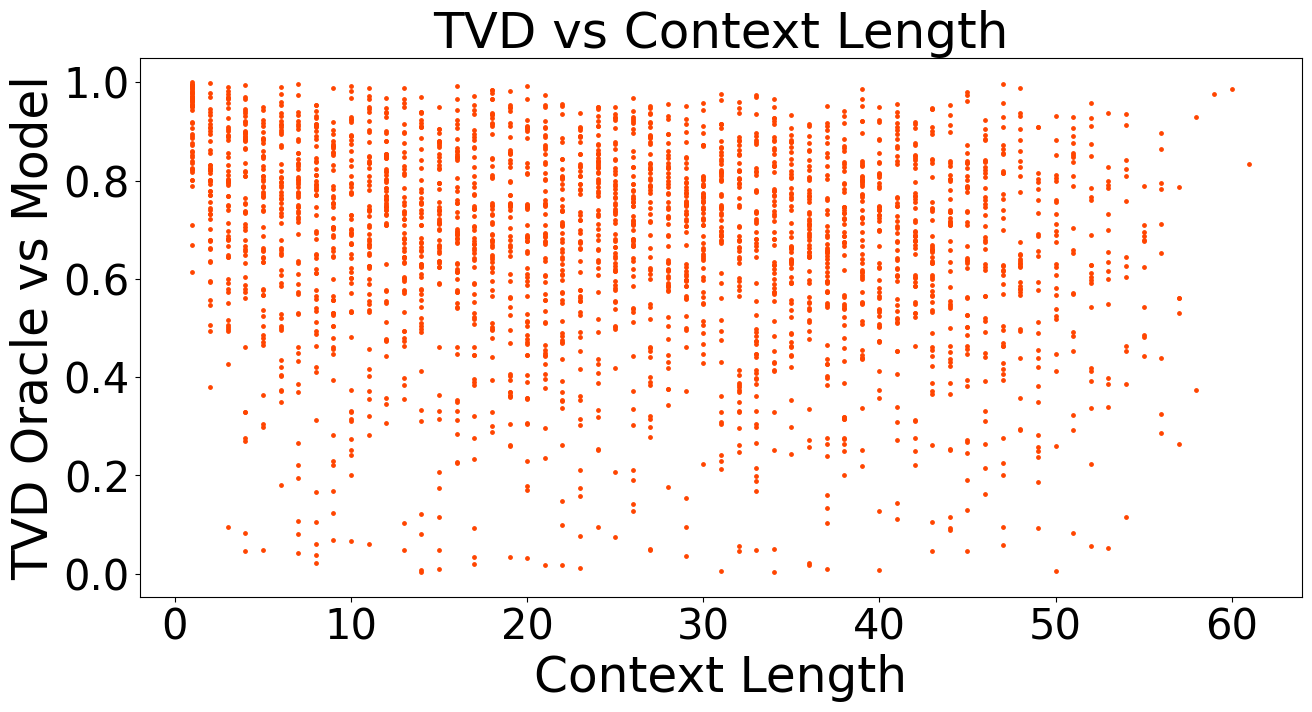

In [7]:
plt.rc('font', size=30)# controls default text sizes
plt.subplots(figsize=(15, 7))
plt.scatter(dict_results[0]['context_length'], dict_results[0]['tvd_unbiased'],
            s = 6, c = 'orangered')

plt.xlabel('Context Length', fontsize=35)
plt.ylabel('TVD Oracle vs Model', fontsize=35)

plt.title("TVD vs Context Length")
plt.savefig('TVDvsContextlength.pdf', format="pdf",bbox_inches='tight')


plt.show()

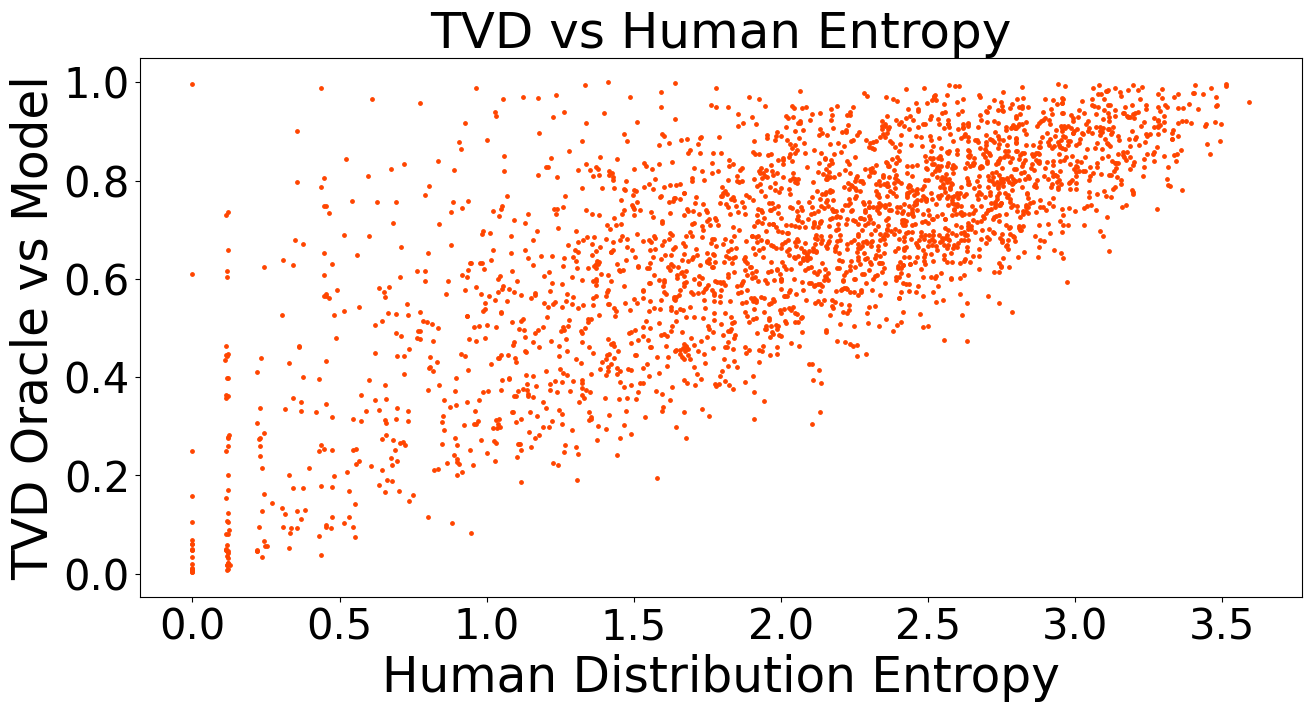

In [8]:
plt.rc('font', size=30)# controls default text sizes
plt.subplots(figsize=(15, 7))
plt.scatter(dict_results[0]['ent_human'], dict_results[0]['tvd_unbiased'], s = 6, c = 'orangered')

plt.xlabel('Human Distribution Entropy', fontsize=35)
plt.ylabel('TVD Oracle vs Model', fontsize=35)

plt.title("TVD vs Human Entropy")
plt.savefig('TVDvsHumanEntropy.pdf', format="pdf",bbox_inches='tight')


plt.show()

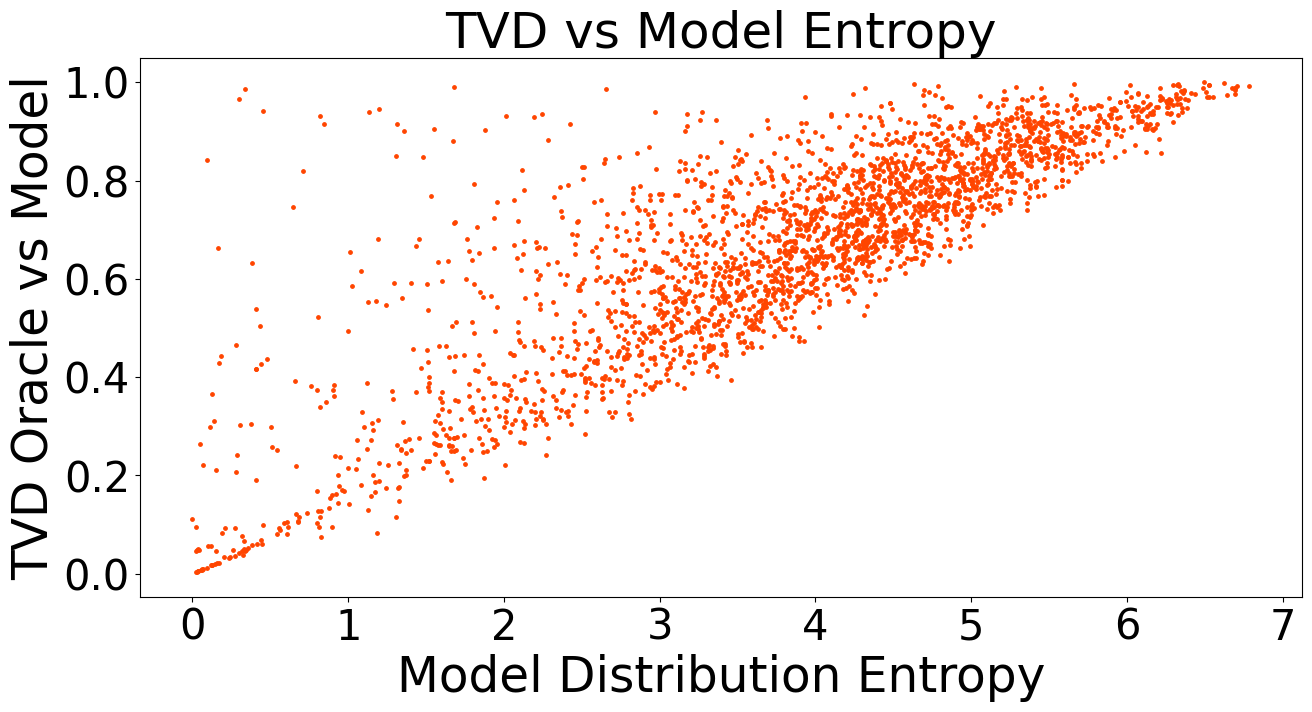

In [9]:
plt.rc('font', size=30)# controls default text sizes
plt.subplots(figsize=(15, 7))
plt.scatter(dict_results[0]['ent_model'], dict_results[0]['tvd_unbiased'], s = 6, c = 'orangered')

plt.xlabel('Model Distribution Entropy', fontsize=35)
plt.ylabel('TVD Oracle vs Model', fontsize=35)

plt.title("TVD vs Model Entropy")
plt.savefig('TVDvsModelEntropy.pdf', format="pdf",bbox_inches='tight')

plt.show()

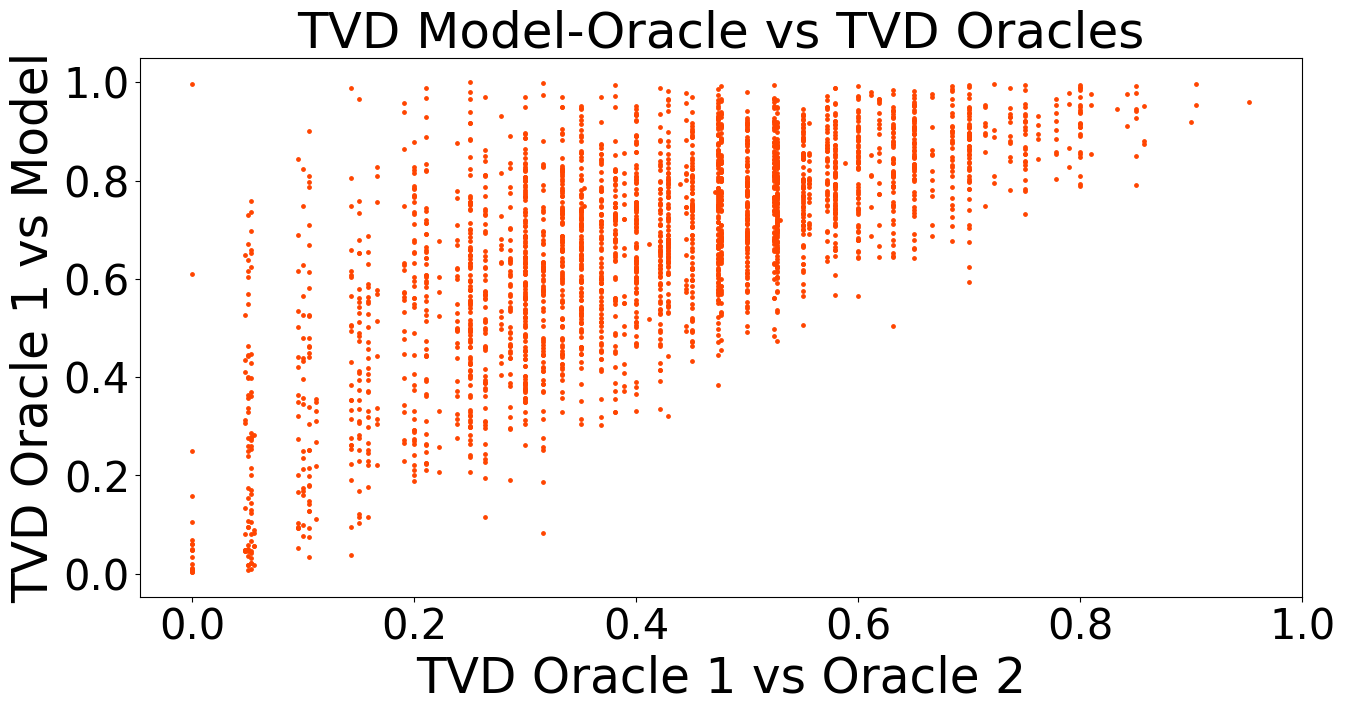

In [10]:
plt.rc('font', size=30)# controls default text sizes
plt.subplots(figsize=(15, 7))
plt.scatter(dict_results[0]['tvd_oracles'], dict_results[0]['tvd_unbiased'], s = 6, c = 'orangered')

plt.xlabel('TVD Oracle 1 vs Oracle 2', fontsize=35)
plt.ylabel('TVD Oracle 1 vs Model', fontsize=35)

plt.title("TVD Model-Oracle vs TVD Oracles")
plt.savefig('TVDmodel_oraclevsTVDoracles.pdf', format="pdf",bbox_inches='tight')

plt.show()

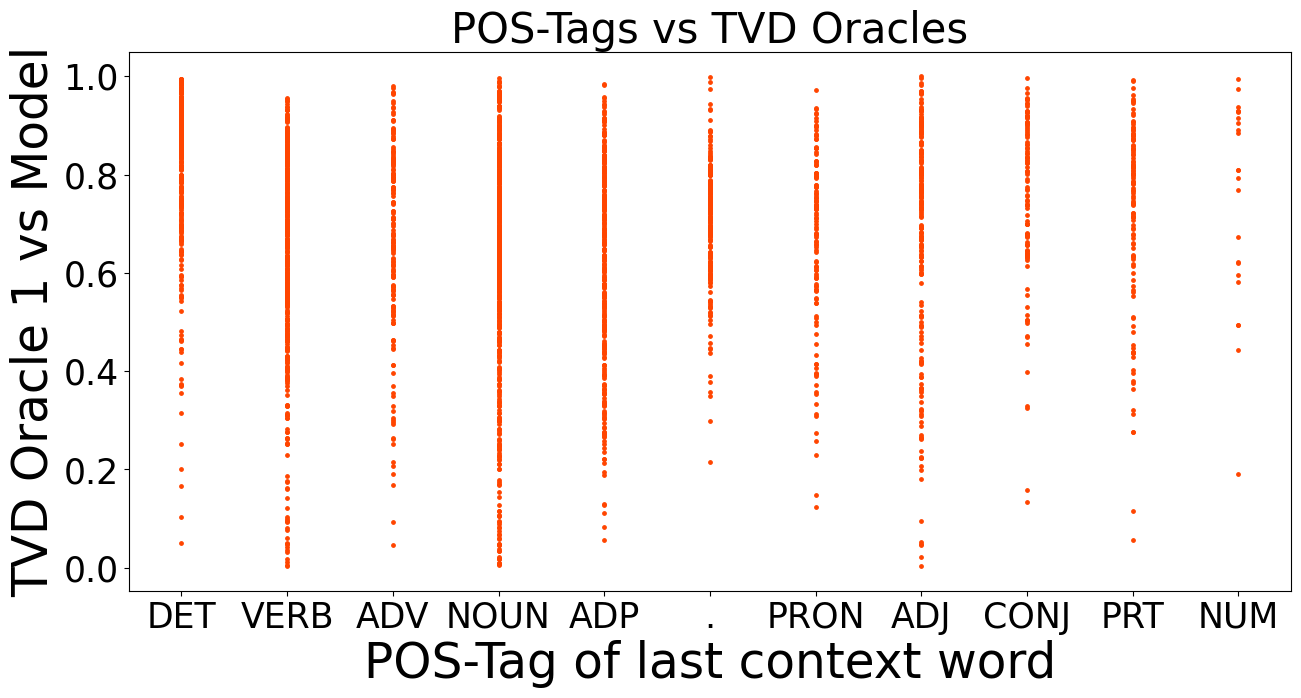

In [11]:
plt.rc('font', size=25)# controls default text sizes
plt.subplots(figsize=(15, 7))
plt.scatter(dict_results[0]['context_last_pos_tag'], dict_results[0]['tvd_unbiased'], s = 6, c = 'orangered')

plt.xlabel('POS-Tag of last context word', fontsize=35)
plt.ylabel('TVD Oracle 1 vs Model', fontsize=35)

plt.title("POS-Tags vs TVD Oracles")
plt.savefig('pos_tags_vs_TVDoracles.pdf', format="pdf",bbox_inches='tight')

plt.show()

In [12]:
cat_last_pos_tag = pd.get_dummies(dict_results[0]['context_last_pos_tag'], dtype = float)
cat_last_pos_tag


,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2682,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2683,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2684,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2685,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from sklearn import linear_model


In [14]:
clf = linear_model.ARDRegression()

In [15]:
y = dict_results[0]['tvd_unbiased']

x_1 = dict_results[0]['ent_human']
x_2 = dict_results[0]['ent_model']
x_3 = dict_results[0]['tvd_oracles']
x_4 = dict_results[0]['context_length']
x_punct = cat_last_pos_tag['.'].tolist()
x_adj = cat_last_pos_tag['ADJ'].tolist()
x_adp = cat_last_pos_tag['ADP'].tolist()
x_adv =cat_last_pos_tag['ADV'].tolist()
x_conj = cat_last_pos_tag['CONJ'].tolist()
x_det = cat_last_pos_tag['DET'].tolist()
x_noun = cat_last_pos_tag['NOUN'].tolist()
x_num = cat_last_pos_tag['NUM'].tolist()
x_pron = cat_last_pos_tag['PRON'].tolist()
x_prt = cat_last_pos_tag['PRT'].tolist()
x_verb = cat_last_pos_tag['VERB'].tolist()

In [16]:
x = np.array([[x_1[i],x_2[i],x_3[i],x_4[i], x_punct[i], x_adj[i], x_adp[i], x_adv[i], x_conj[i], x_det[i], x_noun[i], x_num[i], x_pron[i], x_prt[i], x_verb[i]] for i in range(len(x_1))])
y = np.array(y)

In [17]:
clf.fit(x, y)

ARDRegression()

In [18]:
clf.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'max_iter': None,
 'n_iter': 'deprecated',
 'threshold_lambda': 10000.0,
 'tol': 0.001,
 'verbose': False}

In [19]:
clf.coef_

array([ 0.05261722,  0.09541563,  0.11515043,  0.        , -0.01043499,
        0.01597715, -0.02599172,  0.        ,  0.        ,  0.        ,
        0.        ,  0.04867328,  0.        ,  0.        ,  0.        ])

In [20]:
clf.coef_ + 2 / clf.lambda_

array([ 5.82576380e-02,  1.13636146e-01,  1.43449929e-01,  4.00685873e-06,
       -1.01289847e-02,  1.65906344e-02, -2.45592602e-02,  1.67411866e-04,
        1.27596201e-05,  1.35619146e-05,  3.13232736e-05,  5.42574438e-02,
        3.48697718e-05,  5.53959323e-06,  1.77534182e-04])

In [21]:
clf.coef_ - 2 / clf.lambda_


array([ 4.69767945e-02,  7.71951214e-02,  8.68509379e-02, -4.00685873e-06,
       -1.07409984e-02,  1.53636632e-02, -2.74241838e-02, -1.67411866e-04,
       -1.27596201e-05, -1.35619146e-05, -3.13232736e-05,  4.30891164e-02,
       -3.48697718e-05, -5.53959323e-06, -1.77534182e-04])

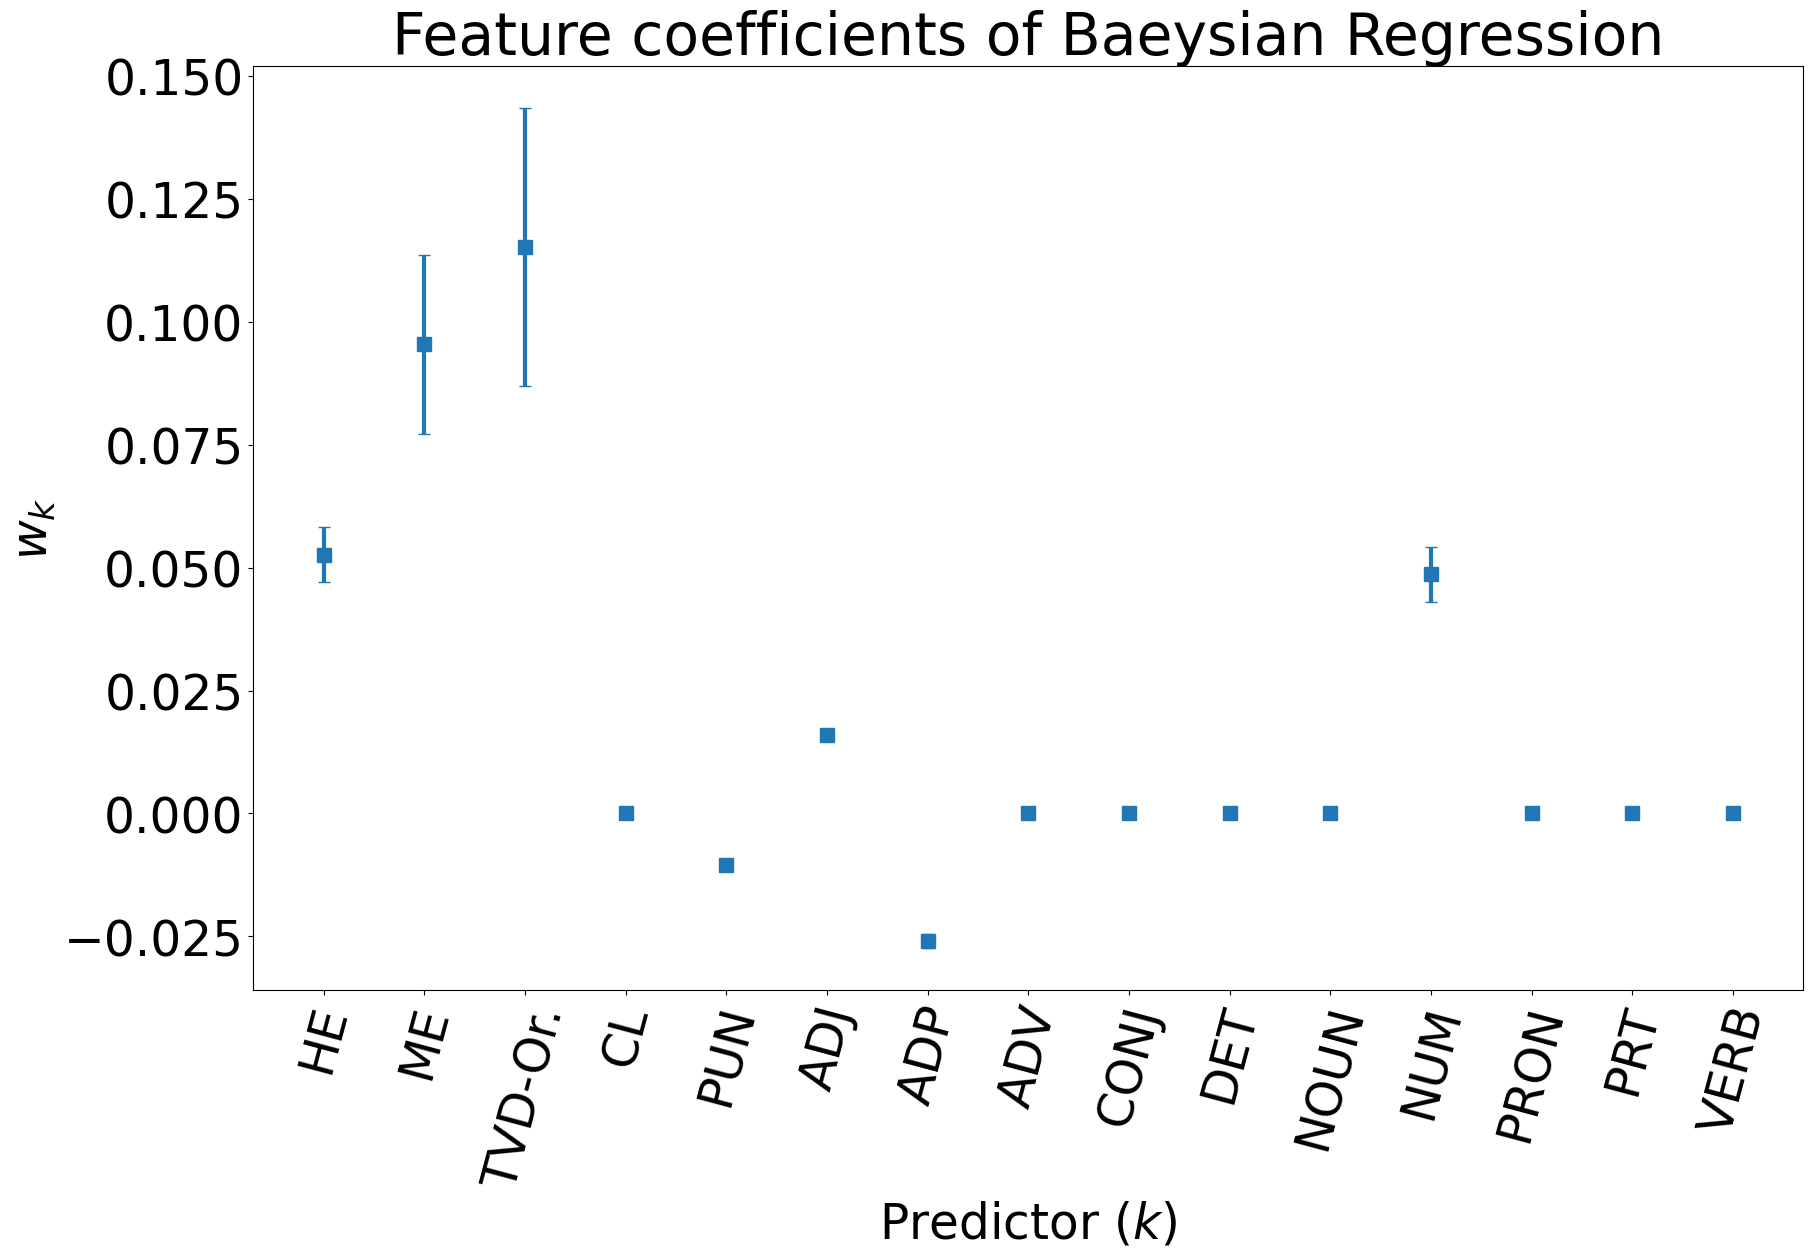

In [22]:
plt.figure(figsize=(20,12))
plt.rc('font', size=35)

ax1 = plt.errorbar(['HE', 'ME', 'TVD-Or.', 'CL', 'PUN', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB'], clf.coef_, 2 / clf.lambda_, linestyle='None', marker='s', errorevery=1, markersize='10', capsize=4, elinewidth=3)
plt.xlabel(r"Predictor ($k$)")
plt.ylabel(r"$w_k$")
plt.xticks(rotation=75)
plt.title('Feature coefficients of Baeysian Regression')

plt.savefig('Bayesian_regr_coeff.pdf', format="pdf",bbox_inches='tight')
